In [1]:
import os
import sys
from collections import defaultdict

import pydicom
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import binary_closing, binary_erosion  # Morphological operator

MRI_FRAMES = 50
MRI_MIN_RADIUS = 2
MRI_MAX_MYOCARDIUM = 20
MRI_BIG_RADIUS_FACTOR = 0.9
MRI_SMALL_RADIUS_FACTOR = 0.19
MRI_SEGMENTED_CHANNEL_MAP = {'background': 0, 'ventricle': 1, 'myocardium': 2}

In [28]:
!mkdir ./dcm_scratch
!rm ./dcm_scratch/*

!cp /mnt/ml4cvd/projects/bulk/cardiac_mri/2467677_20209_2_0.zip ./dcm_scratch/
!unzip ./dcm_scratch/2467677_20209_2_0.zip -d ./dcm_scratch/

mkdir: cannot create directory ‘./dcm_scratch’: File exists
Archive:  ./dcm_scratch/2467677_20209_2_0.zip
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184728862415529.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184727891215527.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184730872615531.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184757769615560.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184775056515576.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184745810315543.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184796992115601.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184794835915598.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184797334315602.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713184806915606.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713185276091515806.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713185276686615807.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171319123878315920.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171319121627715915.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191211088015930.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191261745715981.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191278322516001.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191277967916000.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191278980816003.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191278652216002.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713191287977816007.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.20

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193593191316330.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193632924916373.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193650948016393.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193635998116377.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193585225916320.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193582347416316.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193587834516323.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193593563116331.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713193597836716334.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171319361142316337.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171319363486716343.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.20

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200213164416795.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171320025081116787.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200214145616797.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200214702416798.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200215204016799.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200223863116807.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200137092316696.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200140906216712.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200141328216715.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200145244216723.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713200149325716726.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202591733017151.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202590824817150.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171320264528517167.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171320265333417168.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202616296417182.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202614961517178.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202616718817183.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202627166417192.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202628084517196.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202629116117198.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713202629495917199.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.20

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210638235418919.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210639840318929.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210640160918931.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210641128518937.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210641449918939.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210641770318941.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210489684218088.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210490471718092.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210490866818094.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210491667718098.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210494826718114.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210555089618438.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210555455918440.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210555820418442.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210556184318444.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210556915618448.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210557655818452.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210558366118456.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210559060618460.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210559407818462.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210559752418464.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210510515418196.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210464836017960.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210466762917970.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210467534017974.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210468305717978.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210468691617980.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210469847817986.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210470234917988.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210572229318536.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210573272518542.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210573617318544.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210574310518548.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210582803118606.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210583091718608.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210584806718620.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210585092318622.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210585378318624.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210586234518630.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210586802218634.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210587375518638.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210438073217818.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210438439217820.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210438806417822.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210496858418124.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210497627818128.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210498785218134.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210499169818136.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210499555318138.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.20160317132105324518142.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171321051479218148.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171321052645318154.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171321051864118150.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171321063785018705.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.201603171321053019818156.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031

  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210479502418036.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210479885618038.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210579365818582.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210579652018584.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210581078218594.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210581375518596.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210581661418598.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210581945418600.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210583662918612.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210583948118614.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.2016031713210528694618294.dcm  
  inflating: ./dcm_scratch/1.3.12.2.1107.5.2.18.41754.

In [29]:
dcm_dir = './dcm_scratch/'
series = defaultdict(list)
for dcm_file in os.listdir(dcm_dir):
    if not dcm_file.endswith('.dcm'):
        continue
    dcm = pydicom.read_file(dcm_dir + dcm_file)
    if 'cine_segmented_sax_inlinevf' == dcm.SeriesDescription.lower():
        cur_angle = (dcm.InstanceNumber - 1) // MRI_FRAMES 
        series[cur_angle].append(dcm)
print('len is:' , len(series))
for k in series:
    print(f'b series {k} has {len(series[k])} instances')

len is: 12
b series 1 has 50 instances
b series 2 has 50 instances
b series 4 has 50 instances
b series 7 has 50 instances
b series 8 has 50 instances
b series 10 has 50 instances
b series 0 has 50 instances
b series 9 has 50 instances
b series 3 has 50 instances
b series 11 has 50 instances
b series 6 has 50 instances
b series 5 has 50 instances


In [30]:
MRI_MIN_RADIUS = 2
MRI_MAX_MYOCARDIUM = 20
MRI_BIG_RADIUS_FACTOR = 0.9
MRI_SMALL_RADIUS_FACTOR = 0.19
MRI_SEGMENTED_CHANNEL_MAP = {'background': 0, 'ventricle': 1, 'myocardium': 2}
def _is_mitral_valve_segmentation(d) -> bool:
    return d.SliceThickness == 6

def _get_overlay_from_dicom(d, debug=False):
    """Get an overlay from a DICOM file

    Morphological operators are used to transform the pixel outline of the myocardium
    to the labeled pixel masks for myocardium and left ventricle

    Arguments
        d: the dicom file
        stats: Counter to keep track of summary statistics

    Returns
        Tuple of two numpy arrays.
        The first is the raw overlay array with myocardium outline,
        The second is a pixel mask with 0 for background 1 for myocardium and 2 for ventricle
    """
    i_overlay = 0
    dicom_tag = 0x6000 + 2 * i_overlay
    overlay_raw = d[dicom_tag, 0x3000].value
    rows = d[dicom_tag, 0x0010].value  # rows = 512
    cols = d[dicom_tag, 0x0011].value  # cols = 512
    overlay_frames = d[dicom_tag, 0x0015].value
    bits_allocated = d[dicom_tag, 0x0100].value

    np_dtype = np.dtype('uint8')
    length_of_pixel_array = len(overlay_raw)
    expected_length = rows * cols
    if bits_allocated == 1:
        expected_bit_length = expected_length
        bit = 0
        overlay = np.ndarray(shape=(length_of_pixel_array * 8), dtype=np_dtype)
        for byte in overlay_raw:
            for bit in range(bit, bit + 8):
                overlay[bit] = byte & 0b1
                byte >>= 1
            bit += 1
        overlay = overlay[:expected_bit_length]
    if overlay_frames == 1:
        overlay = overlay.reshape(rows, cols)
        idx = np.where(overlay == 1)
        min_pos = (np.min(idx[0]), np.min(idx[1]))
        max_pos = (np.max(idx[0]), np.max(idx[1]))
        short_side = min((max_pos[0] - min_pos[0]), (max_pos[1] - min_pos[1]))
        small_radius = max(MRI_MIN_RADIUS, short_side * MRI_SMALL_RADIUS_FACTOR)
        big_radius = max(MRI_MIN_RADIUS+1, short_side * MRI_BIG_RADIUS_FACTOR)
        small_structure = _unit_disk(small_radius)
        m1 = binary_closing(overlay, small_structure).astype(np.int)
        big_structure = _unit_disk(big_radius)
        m2 = binary_closing(overlay, big_structure).astype(np.int)
        anatomical_mask = m1 + m2
        ventricle_pixels = np.count_nonzero(anatomical_mask == MRI_SEGMENTED_CHANNEL_MAP['ventricle'])
        myocardium_pixels = np.count_nonzero(anatomical_mask == MRI_SEGMENTED_CHANNEL_MAP['myocardium'])
        if ventricle_pixels == 0 and myocardium_pixels > MRI_MAX_MYOCARDIUM:
            erode_structure = _unit_disk(small_radius*1.5)
            anatomical_mask = anatomical_mask - binary_erosion(m1, erode_structure).astype(np.int)
            ventricle_pixels = np.count_nonzero(anatomical_mask == MRI_SEGMENTED_CHANNEL_MAP['ventricle'])
            print(f"rescue ventricle_pixels {ventricle_pixels} myo pixels: {myocardium_pixels} ")
        return overlay, anatomical_mask, ventricle_pixels
    
def _unit_disk(r) -> np.ndarray:
    y, x = np.ogrid[-r: r + 1, -r: r + 1]
    return (x ** 2 + y ** 2 <= r ** 2).astype(np.int)


def _outline_to_mask(labeled_outline, idx) -> np.ndarray:
    idx = np.where(labeled_outline == idx)
    poly = list(zip(idx[1].tolist(), idx[0].tolist()))
    img = Image.new("L", [labeled_outline.shape[1], labeled_outline.shape[0]], 0)
    ImageDraw.Draw(img).polygon(poly, outline=1, fill=1)
    return np.array(img)

In [31]:
def plot_b_series(b_series, sides=7):
    _, axes = plt.subplots(sides, sides, figsize=(18, 24))
    for dcm in b_series:
        idx = (dcm.InstanceNumber-1)%50
        if idx >= sides*sides:
            continue
        if _is_mitral_valve_segmentation(dcm):
            axes[idx%sides, idx//sides].imshow(dcm.pixel_array, cmap='gray')
        else:
            try:
                overlay, anatomical_mask, ventricle_pixels = _get_overlay_from_dicom(dcm)
                #axes[idx%sides, idx//sides].imshow(np.ma.masked_where(anatomical_mask == 2, dcm.pixel_array), cmap='gray')
                axes[idx%sides, idx//sides].imshow(dcm.pixel_array, cmap='gray')
            except KeyError:
                print(f'Could not get overlay at {dcm.InstanceNumber}, angle {s}')
                axes[idx, idx//sides].imshow(dcm.pixel_array)
        axes[idx%sides, idx//sides].set_yticklabels([])
        axes[idx%sides, idx//sides].set_xticklabels([])

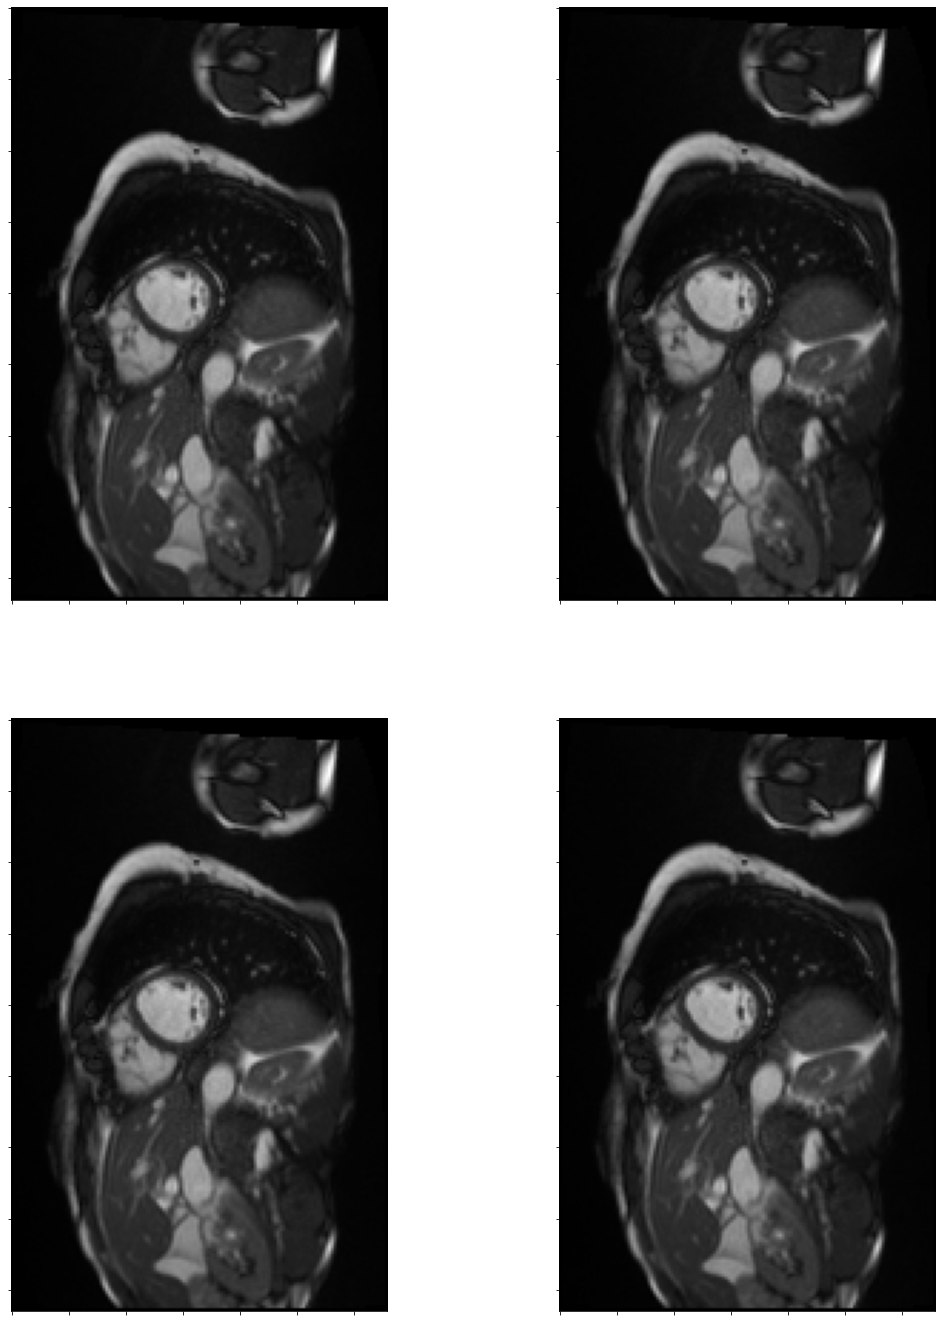

In [32]:
plot_b_series(series[4], sides=2)

In [ ]:
plot_b_series(series[8], sides=7)

In [ ]:
plot_b_series(series[5], sides=7)

In [ ]:
systoles = {}
diastoles = {}
systoles_pix = {}
diastoles_pix = {}
_, axes = plt.subplots(50, 12, figsize=(12, 36))
for s in series:
    for dcm in series[s]:
        if _is_mitral_valve_segmentation(dcm):
            axes[(dcm.InstanceNumber-1)%50, s].imshow(dcm.pixel_array)
            continue
        try:
            overlay, anatomical_mask, ventricle_pixels = _get_overlay_from_dicom(dcm)
            axes[(dcm.InstanceNumber-1)%50, s].imshow(np.ma.masked_where(anatomical_mask == 2, dcm.pixel_array))
            axes[(dcm.InstanceNumber-1)%50, s].set_yticklabels([])
            axes[(dcm.InstanceNumber-1)%50, s].set_xticklabels([])
        except KeyError:
            print(f'could get overlay at {dcm.InstanceNumber}, angle {s}')
            axes[(dcm.InstanceNumber-1)%50, s].imshow(dcm.pixel_array)
        if s not in diastoles:
            diastoles[s] = dcm
            diastoles_pix[s] = ventricle_pixels
            systoles[s] = dcm
            systoles_pix[s] = ventricle_pixels
        else:
            if ventricle_pixels > diastoles_pix[s]:
                diastoles[s] = dcm
                diastoles_pix[s] = ventricle_pixels
            if ventricle_pixels < systoles_pix[s]:
                systoles[s] = dcm
                systoles_pix[s] = ventricle_pixels

for angle in diastoles:
    print(f'Found systole at instance {systoles[angle].InstanceNumber}  pix: {systoles_pix[angle]}')
    print(f'Found diastole at instance {diastoles[angle].InstanceNumber}   pix: {diastoles_pix[angle]}\n')

In [ ]:
print (series.keys())